<a href="https://colab.research.google.com/github/MocktaiLEngineer/PyNN-Less/blob/main/Feedforward_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
A simple walkthrough of how to code a fully connected neural network
using the PyTorch library. For demonstration we train it on the very
common MNIST dataset of handwritten digits. In this code we go through
how to create the network as well as initialize a loss function, optimizer,
check accuracy and more.
"""

# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!

# Here we create our simple neural network. For more details here we are subclassing and
# inheriting from nn.Module, this is the most general way to create your networks and
# allows for more flexibility. I encourage you to also check out nn.Sequential which
# would be easier to use in this scenario but I wanted to show you something that
# "always" works and is a general approach.
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers
        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)
        """
        super(NN, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        Parameters:
            x: mnist images
        Returns:
            out: the output of the network
        """

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 3

# Load Data
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Initialize network
model = NN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape
        data = data.reshape(data.shape[0], -1)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()


# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    """
    Check accuracy of our trained model given a loader and a model
    Parameters:
        loader: torch.utils.data.DataLoader
            A loader for the dataset you want to check accuracy on
        model: nn.Module
            The model you want to check accuracy on
    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader
    """

    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Get to correct shape
            x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 938/938 [00:06<00:00, 135.34it/s]


Accuracy on training set: 96.31
Accuracy on test set: 95.85


In [29]:
import cv2
import numpy as np
size = 28,28

def get_pred(img_path):
    # Load the custom image
    image = cv2.imread(img_path)

    # Preprocess the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, size)

    # Convert the preprocessed image to a NumPy array and normalize the pixel values
    data = np.asarray(resized) / 255.0

    # Reshape the NumPy array to a 1D array
    data = data.reshape(1, -1)

    # Convert the NumPy array to a PyTorch tensor
    data = torch.tensor(data).float().to(device)

    # Pass the tensor to the pre-trained model to get the predicted class label
    output = model(data)
    _, predicted = torch.max(output, 1)

    return predicted

answer = get_pred('nine.png')
print(answer.item())

9


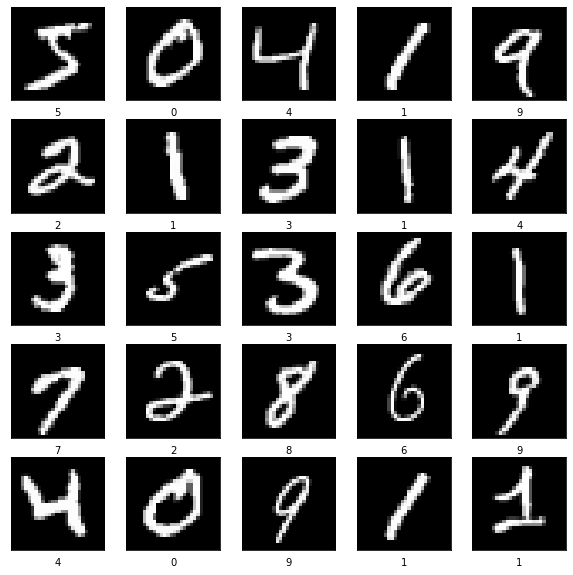

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = train_dataset[i][0]
    if image.shape[0] == 1:
        image = image[0, :, :]
    plt.imshow(image, cmap='gray')
    plt.xlabel(train_dataset[i][1])
plt.show()